In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
import torch
from torch.nn import ReLU
import torch.nn as nn
from matplotlib import pyplot as plt
from collections import OrderedDict
from typing import Optional
from torch.nn.utils import clip_grad_norm_
from collections import defaultdict
from tqdm import tqdm

# hyperparams.

In [3]:
seed_init = 0
hiddens = [15, 15, 15]
n_iters_gd = 20_000
n_iters_sgd = 200_000
n_iters_gdwd = 5_000
n_trajs = 4
lr = 0.1

# util functions.

In [4]:
def seedall(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

# data generation.

In [5]:
n = 5000 # number of samples.
d = 15 # dimension of the data.
r = 5 # end-index of relevant features.

seedall(seed_init)

# Sample raw data at first.
x = np.random.randn(n, d)

# Prepare the data as per assumptions.
idx_to_center = range(r, d)
means = np.mean(x[:, idx_to_center], axis=0)
x[:, idx_to_center] -= means

# Define generating function.
W = np.array([1] * d) # np.random.randn(d)
W[r:] = 0 # Set to zero irrelevant features.

# Gaussian noise.
eps = 0.001 * np.random.randn(n)

# Generate labels.
y1 = ((x @ W) + eps).reshape(-1, 1) # Linear.
y2 = ((x @ W) - eps).reshape(-1, 1) # Linear rev.

x = np.concatenate([x, x], axis=0)
y = np.concatenate([y1, y2], axis=0)

# Map to PyTorch tensors.
xt = torch.from_numpy(x).float()
yt = torch.from_numpy(y).float()

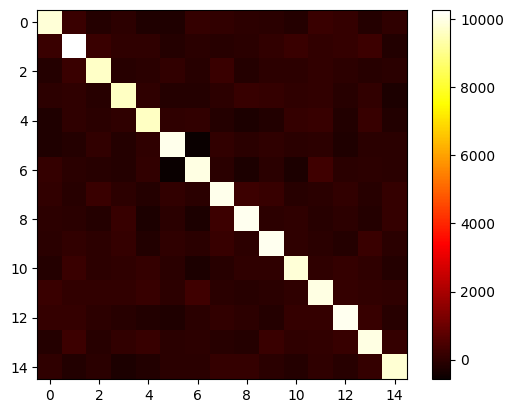

In [6]:
# Ensure that data features are not correlated.
cov = xt.T @ xt
plt.imshow(cov, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show();

# define our proper model.

In [7]:
class LinearBlock(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        act_func: Optional[nn.Module] = None,
        skip_connections: bool = False
    ):
        super().__init__()
        modules = OrderedDict()
        modules["linear"] = nn.Linear(in_features=in_features, out_features=out_features, bias=bias)
        modules["activation"] = act_func if act_func is not None else nn.Identity()
        self.linear_act_block = nn.Sequential(modules)
        self.skip_connections = skip_connections
        if skip_connections and in_features != out_features:
            self.adjust_dim = nn.Linear(in_features, out_features, bias=False)
        else:
            self.adjust_dim = None

    def forward(self, x):
        if self.skip_connections:
            x_adj = self.adjust_dim(x) if self.adjust_dim is not None else x
            return x_adj + self.linear_act_block(x)
        return self.linear_act_block(x)

class MLP(nn.Module):
    def __init__(
        self,
        in_features: int,
        hidden_features: list[int],
        out_features: int,
        bias: bool = True,
        act_func: Optional[nn.Module] = None,
        skip_connections: bool = False,
        init_method: str = "he_normal"
    ) -> None:
        super(MLP, self).__init__()
        assert len(hidden_features) >= 1

        modules = OrderedDict()
        hidden_dims = [in_features] + hidden_features + [out_features]

        for i in range(len(hidden_dims) - 1):
            modules[f"layer_{i}"] = LinearBlock(
                in_features=hidden_dims[i],
                out_features=hidden_dims[i + 1],
                skip_connections=skip_connections,
                # Use the activation function for all layers but last fc
                act_func=act_func if i < len(hidden_dims) - 2 else None,
                bias=bias,
            )

        self.layers = nn.Sequential(modules)
        self.init_weights(self.layers, init_method)
        self.penultimate = None
        self.set_init()

    def init_weights(self, module, init_method):
        for child in module.children():
            if isinstance(child, nn.Linear):
                self.apply_init(child, init_method)
            else:
                self.init_weights(child, init_method)

    def apply_init(self, linear_layer, init_method):
        if init_method == "xavier_uniform":
            nn.init.xavier_uniform_(linear_layer.weight)
        elif init_method == "xavier_normal":
            nn.init.xavier_normal_(linear_layer.weight)
        elif init_method == "he_normal":
            nn.init.kaiming_normal_(linear_layer.weight, nonlinearity="relu")
        elif init_method == "he_uniform":
            nn.init.kaiming_uniform_(linear_layer.weight, nonlinearity="relu")

    def embeddings(self, x):
        activations = []
        for layer in self.layers[:-1]:
            x = layer(x)
            activations.append(x)
        return activations

    def forward(self, x):
        self.penultimate = self.layers[:-1](x)
        logits = self.layers[-1](self.penultimate)
        return logits
    
    def set_init(self):
        self.W1_init = self.layers.layer_0.linear_act_block.linear.weight.detach().clone().numpy()
        self.W2_init = self.layers.layer_1.linear_act_block.linear.weight.detach().clone().numpy()
        self.W3_init = self.layers.layer_2.linear_act_block.linear.weight.detach().clone().numpy()
        self.u_init, self.s_init, self.vh_init = np.linalg.svd(self.W1_init)
        self.W1_init_svd = self.W1_init @ self.vh_init.T

    def set_post(self):
        self.W1_post = self.layers.layer_0.linear_act_block.linear.weight.detach().clone().numpy()
        self.W2_post = self.layers.layer_1.linear_act_block.linear.weight.detach().clone().numpy()
        self.W3_post = self.layers.layer_2.linear_act_block.linear.weight.detach().clone().numpy()
        # self.u_post, self.s_post, self.vh_post = np.linalg.svd(self.W1_post)
        # self.W1_post_svd = self.W1_post @ self.vh_post.T
    
    @staticmethod
    def norm(model):
        norm = 0
        for param in model.parameters():
            norm += param.data.norm(2) ** 2
        return norm

# training loops utils.

In [8]:
def train(model, train_loader, crit, opt, n_iters, seed_traj=0, clip_value=1.0):
    # Set the seed.
    seedall(seed_traj)

    model.train()
    pbar = tqdm(range(n_iters))
    iters_idx, epoch_idx = 0, 0
    losses, irelnorms = [], []

    while iters_idx < n_iters:
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if iters_idx >= n_iters: break

            # forward pass.
            outputs = model(inputs)
            
            # backward pass.
            opt.zero_grad()
            loss = crit(outputs, targets)
            loss.backward()
            if clip_value > 0:
                clip_grad_norm_(model.parameters(), clip_value)
            opt.step()
            losses.append(loss.item())
            irelnorms.append(np.linalg.norm(model.layers.layer_0.linear_act_block.linear.weight.detach().numpy()[:,r:d]))

            # move progress bar.
            pbar.set_description(f"epoch {epoch_idx+1} iter {iters_idx+1}/{n_iters} | train loss {loss.item():.3f} | norm {model.norm(model):.3f}")
            pbar.update(1)
            iters_idx += 1

        epoch_idx += 1

    model.set_post()
    model.irelnorms = irelnorms
    model.losses = losses
    pbar.close()

## magic functions.

In [9]:
def experiment(bs, lr, wd, hiddens, n_iters, with_relu=False, seed_traj=0):
    # set the init seed.
    seedall(seed_init)
    
    # create dataloader.
    dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(xt, yt),
        batch_size=bs if bs > 0 else n*2, # set bs = -1 for GD.
        shuffle=True
    )

    # set model
    model = MLP(
        in_features=d,
        hidden_features=hiddens,
        out_features=1,
        act_func=ReLU() if with_relu else None,
        bias=False
    )

    # set optim and train.
    opt = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    crit = torch.nn.MSELoss()
    train(model, dataloader, crit, opt, n_iters, seed_traj)

    return model # model contains all infos.

# run the experiments

In [10]:
model_gd = experiment(-1, lr, 0.0, hiddens, n_iters=n_iters_gd)

epoch 13 iter 13/20000 | train loss 0.609 | norm 88.801:   0%|          | 12/20000 [00:00<16:01, 20.79it/s]

In [ ]:
model_sgd512 = []
for seed_traj in range(n_trajs):
    print(f'seeding trajectory {seed_traj}')
    model_sgd512.append(experiment(512, lr, 0.0, hiddens, n_iters=n_iters_sgd))

In [ ]:
model_sgd128 = []
for seed_traj in range(n_trajs):
    print(f'seeding trajectory {seed_traj}')
    model_sgd128.append(experiment(128, lr, 0.0, hiddens, n_iters=n_iters_sgd))

In [ ]:
model_sgd32 = []
for seed_traj in range(n_trajs):
    print(f'seeding trajectory {seed_traj}')
    model_sgd32.append(experiment(32, lr, 0.0, hiddens, n_iters=n_iters_sgd))

In [ ]:
model_sgd01 = []
for seed_traj in range(n_trajs):
    print(f'seeding trajectory {seed_traj}')
    model_sgd01.append(experiment(1, lr, 0.0, hiddens, n_iters=n_iters_sgd))

In [ ]:
model_gdwd = experiment(-1, lr, 0.1, hiddens, n_iters=n_iters_gdwd)

# gram matrices of first layer.

In [ ]:
W1_init = model_gd.W1_init
W1_gd = model_gd.W1_post
W1_sgd512 = model_sgd512[0].W1_post
W1_sgd128 = model_sgd128[0].W1_post
W1_sgd32 = model_sgd32[0].W1_post
W1_sgd01 = model_sgd01[0].W1_post
W1_gdwd = model_gdwd.W1_post

In [ ]:
G1_init = abs(W1_init.T @ W1_init)
G1_gd = abs(W1_gd.T @ W1_gd)
G1_sgd512 = abs(W1_sgd512.T @ W1_sgd512)
G1_sgd128 = abs(W1_sgd128.T @ W1_sgd128)
G1_sgd32 = abs(W1_sgd32.T @ W1_sgd32)
G1_sgd01 = abs(W1_sgd01.T @ W1_sgd01)
G1_gdwd = abs(W1_gdwd.T @ W1_gdwd)

In [ ]:
gs1 = [G1_init, G1_gd, G1_sgd512, G1_sgd128, G1_sgd32, G1_sgd01, G1_gdwd]
titles = ['Gram W1 at init.', 'GD', 'SGD-512', 'SGD-128', 'SGD-32', 'SGD-01', 'GD+wd (Gold)']

def minmax(x):
    return (x - x.min()) / (x.max() - x.min())

gs1 = [minmax(g ** 0.95) for g in gs1]
vmin = min([g.min() for g in gs1])
vmax = max([g.max() for g in gs1])

fig, axs = plt.subplots(1, len(titles), figsize=(16, len(gs1)))
for i, g in enumerate(gs1):
    im = axs[i].imshow(g, cmap='magma', interpolation='nearest', vmin=vmin, vmax=vmax)
    axs[i].set_title(f"{titles[i]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show();

# irelnorms lines :)

In [ ]:
def plot_median_and_percentiles(data, label, color):
    data = np.array(data)
    median = np.median(data, axis=0)
    percentile_10 = np.percentile(data, 10, axis=0)
    percentile_90 = np.percentile(data, 90, axis=0)
    plt.plot(median, label=label, color=color)
    plt.fill_between(range(len(median)), percentile_10, percentile_90, color=color, alpha=0.3)

In [ ]:
irelnorms_gd = model_gd.irelnorms
irelnorms_sgd512 = [model_sgd512[t].irelnorms for t in range(n_trajs)]
irelnorms_sgd128 = [model_sgd128[t].irelnorms for t in range(n_trajs)]
irelnorms_sgd32 = [model_sgd32[t].irelnorms for t in range(n_trajs)]
irelnorms_sgd01 = [model_sgd01[t].irelnorms for t in range(n_trajs)]
irelnorms_gdwd = model_gdwd.irelnorms

# pad irelnorms_gdwd with 0s to match irelnorms_sgd512 len
irelnorms_gdwd = irelnorms_gdwd + [0] * (len(irelnorms_sgd512[0]) - len(irelnorms_gdwd))
irelnorms_gd = irelnorms_gd + [irelnorms_gd[-1]] * (len(irelnorms_sgd512[0]) - len(irelnorms_gd))

In [ ]:
plt.plot(irelnorms_gd, label='gd', color='red') # blue
plot_median_and_percentiles(irelnorms_sgd512, 'sgd-512', 'orange')
plot_median_and_percentiles(irelnorms_sgd128, 'sgd-128', 'blue')
plot_median_and_percentiles(irelnorms_sgd32, 'sgd-32', 'green')
plot_median_and_percentiles(irelnorms_sgd01, 'sgd-01', 'purple')
plt.plot(irelnorms_gdwd, label='gd+wd', color='brown') # brown
plt.title('irrelevant feature/weights norms over iters.')
plt.grid(True, linestyle='-', linewidth=0.2, color='gray')
plt.legend()
plt.xscale('log')
plt.show();

# gram matrices of second layer.

In [ ]:
W2_init = model_gd.W2_init
W2_gd = model_gd.W2_post
W2_sgd512 = model_sgd512[0].W2_post
W2_sgd128 = model_sgd128[0].W2_post
W2_sgd32 = model_sgd32[0].W2_post
W2_sgd01 = model_sgd01[0].W2_post
W2_gdwd = model_gdwd.W2_post

In [ ]:
G2_init = abs(W2_init.T @ W2_init)
G2_gd = abs(W2_gd.T @ W2_gd)
G2_sgd512 = abs(W2_sgd512.T @ W2_sgd512)
G2_sgd128 = abs(W2_sgd128.T @ W2_sgd128)
G2_sgd32 = abs(W2_sgd32.T @ W2_sgd32)
G2_sgd01 = abs(W2_sgd01.T @ W2_sgd01)
G2_gdwd = abs(W2_gdwd.T @ W2_gdwd)

In [ ]:
gs2 = [G2_init, G2_gd, G2_sgd512, G2_sgd128, G2_sgd32, G2_sgd01, G2_gdwd]
titles = ['Gram W2 at init.', 'GD', 'SGD-512', 'SGD-128', 'SGD-32', 'SGD-01', 'GD+wd (Gold)']

def minmax(x):
    return (x - x.min()) / (x.max() - x.min())

gs2 = [minmax(g ** 0.95) for g in gs2]
vmin = min([g.min() for g in gs2])
vmax = max([g.max() for g in gs2])

fig, axs = plt.subplots(1, len(titles), figsize=(16, len(gs2)))
for i, g in enumerate(gs2):
    im = axs[i].imshow(g, cmap='magma', interpolation='nearest', vmin=vmin, vmax=vmax)
    axs[i].set_title(f"{titles[i]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show();

# gram matrices of third layer.

In [ ]:
W3_init = model_gd.W3_init
W3_gd = model_gd.W3_post
W3_sgd512 = model_sgd512[0].W3_post
W3_sgd128 = model_sgd128[0].W3_post
W3_sgd32 = model_sgd32[0].W3_post
W3_sgd01 = model_sgd01[0].W3_post
W3_gdwd = model_gdwd.W3_post

In [ ]:
G3_init = abs(W3_init.T @ W3_init)
G3_gd = abs(W3_gd.T @ W3_gd)
G3_sgd512 = abs(W3_sgd512.T @ W3_sgd512)
G3_sgd128 = abs(W3_sgd128.T @ W3_sgd128)
G3_sgd32 = abs(W3_sgd32.T @ W3_sgd32)
G3_sgd01 = abs(W3_sgd01.T @ W3_sgd01)
G3_gdwd = abs(W3_gdwd.T @ W3_gdwd)

In [ ]:
gs3 = [G3_init, G3_gd, G3_sgd512, G3_sgd128, G3_sgd32, G3_sgd01, G3_gdwd]
titles = ['Gram W2 at init.', 'GD', 'SGD-512', 'SGD-128', 'SGD-32', 'SGD-01', 'GD+wd (Gold)']

def minmax(x):
    return (x - x.min()) / (x.max() - x.min())

gs3 = [minmax(g ** 0.95) for g in gs3]
vmin = min([g.min() for g in gs3])
vmax = max([g.max() for g in gs3])

fig, axs = plt.subplots(1, len(titles), figsize=(16, len(gs3)))
for i, g in enumerate(gs3):
    im = axs[i].imshow(g, cmap='magma', interpolation='nearest', vmin=vmin, vmax=vmax)
    axs[i].set_title(f"{titles[i]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show();